In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

Загрузка данных из датасетта

In [2]:
_CIFAR_IMAGE_SIZE = 32
from numpy import loadtxt

def load_data(path, labels_number=1):
  with tf.io.gfile.GFile(path, 'rb') as f:
    data = f.read()
  offset = 0
  max_offset = len(data) - 1
  coarse_labels = []
  fine_labels = []
  images = []
  while offset < max_offset:
    labels = np.frombuffer(
        data, dtype=np.uint8, count=labels_number, offset=offset
    ).reshape((labels_number,))
    # 1 байт под названия, 1024 * 3 = 3072 байтов под изображение.
    offset += labels_number
    img = (
        np.frombuffer(data, dtype=np.uint8, count=3072, offset=offset)
        .reshape((3, _CIFAR_IMAGE_SIZE, _CIFAR_IMAGE_SIZE))
        .transpose((1, 2, 0))
    )
    offset += 3072
    coarse_labels.append(labels[0])
    fine_labels.append(labels[1])
    images.append(img)
  return [np.array(coarse_labels), np.array(fine_labels), np.array(images)]

def load_labels(path):
    return loadtxt(path, comments="#", delimiter=",", unpack=False, dtype='str')

def load_cifar100():
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-binary.tar.gz"
    dataset = tf.keras.utils.get_file("cifar.tar.gz", url,untar=True, cache_dir='.', cache_subdir='')
    dataset_dir = os.path.join(os.path.dirname(dataset), 'cifar-100-binary')
    CY_train, FY_train, X_train = load_data(os.path.join(dataset_dir, 'train.bin'), labels_number=2)
    CY_test, FY_test, X_test = load_data(os.path.join(dataset_dir, 'test.bin'), labels_number=2)
    C_label = load_labels(os.path.join(dataset_dir, 'coarse_label_names.txt'))
    F_label = load_labels(os.path.join(dataset_dir, 'fine_label_names.txt'))
    
    return X_train, CY_train, FY_train, X_test, CY_test, FY_test, C_label, F_label

In [3]:
X_train, CY_train, FY_train, X_test, CY_test, FY_test, C_label, F_label = load_cifar100()

In [4]:
print(f"{X_train.shape}: 32, 32 - высота и ширина в пикселях, а 3 - количество цветов ")
print(f"{C_label.shape} - количество меток широкого класса")
print(f"{F_label.shape} - количество меток узкого класса")

(50000, 32, 32, 3): 32, 32 - высота и ширина в пикселях, а 3 - количество цветов 
(20,) - количество меток широкого класса
(100,) - количество меток узкого класса


Объяснить, какие элементы вашей сети зависят от количества цветов, какие — от количества классов.

В качестве входных данных сверточная нейровнная сеть (CNN) принимает тензор формы (высота, ширина, кол-во цветов). В нашем случае, это (32, 32, 3).

CIFAR100 имеет 100 выходных классов, поэтому используется последний плотный слой со 100 выходными данными.

In [5]:
# Нормализация значений rgb
X_train, X_test = X_train / 255.0, X_test / 255.0

Построение модели

In [6]:
from tensorflow.keras import layers, models

def getModel():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(100, activation='softmax'))
    return model

In [7]:
model = getModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

**Объяснение каждого слоя** 

В сверточной нейронной сети выходы промежуточных слоев образуют матрицу (изображение) или набор матриц (несколько слоёв изображения).
Основными видами слоев в сверточной нейронной сети являются сверточные слои (англ. convolutional layer), пулинговые слои (англ. pooling layer) и полносвязные слои (англ. fully-connected layer).

Сверточный слой нейронной сети представляет из себя применение операции свертки к выходам с предыдущего слоя, где веса ядра свертки являются обучаемыми параметрами. Еще один обучаемый вес используется в качестве константного сдвига.

Пулинговый слой призван снижать размерность изображения. Чаще всего используется функция максимума или взвешенного среднего. Обучаемых параметров у этого слоя нет.

conv2d - Сверточный 2D слой. Число выходных фильтров W1 = 32. Высота и ширина одной свертки (3,3). Функциф активации 'relu'.

max_pooling2d - Слой подвыборки, снижающий размерность поступивших данных. Размер окна выборки (2,2).

conv2d_1 - Сверточный 2D слой. Число выходных фильтров W1 = 64. Высота и ширина одной свертки (3,3). Функциф активации 'relu'.

max_pooling2d_1 - Слой подвыборки, снижающий размерность поступивших данных. Размер окна выборки (2,2).

conv2d_2 - Сверточный 2D слой. Число выходных фильтров W1 = 128. Высота и ширина одной свертки (3,3). Функциф активации 'relu'.

max_pooling2d_2 - Слой подвыборки, снижающий размерность поступивших данных. Размер окна выборки (2,2).

flatten - Слой преобразующий 2D данные в 1D данные.

dense - Полносвязный слой. Размер выхода слоя units = U = 128. W=256 - размер входного слоя. Функция активации  'relu'.

dense_1 - Полносвязный слой. Размер выхода слоя units = U = 100. W=128 - размер входного слоя. Функция активации 'softmax' нормализованная экспоненциальная функция преобразует вектор из действительных чисел в распределение вероятностей возможных результатов.

In [8]:
def getCompiledModel():
    model = getModel()
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [9]:
model = getCompiledModel()

Обучение на 20 широких классах

In [10]:
his_20 = model.fit(X_train, CY_train, epochs=10)

Epoch 1/10


C:\Users\Artemius\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 20s 12ms/step - loss: 2.5098 - accuracy: 0.2259
Epoch 2/10
1563/1563 [==============================] - 20s 13ms/step - loss: 2.0857 - accuracy: 0.3518
Epoch 3/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.8810 - accuracy: 0.4122
Epoch 4/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.7468 - accuracy: 0.4518
Epoch 5/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.6375 - accuracy: 0.4845
Epoch 6/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.5394 - accuracy: 0.5136
Epoch 7/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.4547 - accuracy: 0.5394
Epoch 8/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.3802 - accuracy: 0.5611
Epoch 9/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.3075 - accuracy: 0.5819
Epoch 10/10
1563/1563 [==============================] - 18s 12ms/step - lo

In [11]:
model.save("./model_20.keras")

In [12]:
С_test_loss, С_test_acc = model.evaluate(X_test, CY_test)

print('Точность на тестовых данных:', С_test_acc)

313/313 [==============================] - 1s 4ms/step - loss: 1.6989 - accuracy: 0.4918
Точность на тестовых данных: 0.4918000102043152


In [13]:
# Получаем набор вероятностей определения каждой категории
С_predictions = model.predict(X_test)

# Находим максимальные вероятности в наборе предсказаний
С_predictions = np.argmax(С_predictions, axis=-1)

from sklearn.metrics import classification_report

print(classification_report(CY_test, С_predictions, target_names=C_label))

313/313 [==============================] - 1s 3ms/step
                                precision    recall  f1-score   support

               aquatic_mammals       0.44      0.40      0.42       500
                          fish       0.53      0.46      0.49       500
                       flowers       0.72      0.68      0.70       500
               food_containers       0.43      0.56      0.49       500
          fruit_and_vegetables       0.60      0.54      0.57       500
  household_electrical_devices       0.51      0.32      0.40       500
           household_furniture       0.53      0.58      0.55       500
                       insects       0.51      0.44      0.48       500
              large_carnivores       0.38      0.42      0.40       500
 large_man-made_outdoor_things       0.62      0.59      0.61       500
  large_natural_outdoor_scenes       0.70      0.62      0.66       500
large_omnivores_and_herbivores       0.44      0.34      0.38       500
        

Обучение на 100 узких классах

In [14]:
his_100 = model.fit(X_train, FY_train, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 19s 12ms/step - loss: 3.9999 - accuracy: 0.0944
Epoch 2/10
1563/1563 [==============================] - 19s 12ms/step - loss: 3.2117 - accuracy: 0.2128
Epoch 3/10
1563/1563 [==============================] - 19s 12ms/step - loss: 2.8093 - accuracy: 0.2827
Epoch 4/10
1563/1563 [==============================] - 18s 12ms/step - loss: 2.5441 - accuracy: 0.3347
Epoch 5/10
1563/1563 [==============================] - 18s 12ms/step - loss: 2.3651 - accuracy: 0.3711
Epoch 6/10
1563/1563 [==============================] - 18s 12ms/step - loss: 2.2339 - accuracy: 0.4008
Epoch 7/10
1563/1563 [==============================] - 18s 12ms/step - loss: 2.1237 - accuracy: 0.4255
Epoch 8/10
1563/1563 [==============================] - 18s 12ms/step - loss: 2.0207 - accuracy: 0.4478
Epoch 9/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1.9405 - accuracy: 0.4661
Epoch 10/10
1563/1563 [==============================] - 18s 12m

In [15]:
model.save("./model_100.keras")

In [16]:
F_test_loss, F_test_acc = model.evaluate(X_test, FY_test)

print('Точность на тестовых данных:', F_test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 2.6472 - accuracy: 0.3583
Точность на тестовых данных: 0.35830000042915344


In [17]:
# Получаем набор вероятностей определения каждой категории
F_predictions = model.predict(X_test)

# Находим максимальные вероятности в наборе предсказаний
F_predictions = np.argmax(F_predictions, axis=-1)

print(classification_report(FY_test, F_predictions, target_names=F_label))
F_report = classification_report(FY_test, F_predictions, target_names=F_label, output_dict = True)


313/313 [==============================] - 1s 3ms/step
               precision    recall  f1-score   support

        apple       0.73      0.69      0.71       100
aquarium_fish       0.51      0.46      0.48       100
         baby       0.26      0.18      0.21       100
         bear       0.22      0.20      0.21       100
       beaver       0.20      0.18      0.19       100
          bed       0.26      0.29      0.27       100
          bee       0.43      0.37      0.40       100
       beetle       0.45      0.27      0.34       100
      bicycle       0.33      0.43      0.37       100
       bottle       0.49      0.52      0.50       100
         bowl       0.25      0.20      0.22       100
          boy       0.16      0.08      0.11       100
       bridge       0.52      0.33      0.40       100
          bus       0.33      0.32      0.33       100
    butterfly       0.25      0.21      0.23       100
        camel       0.33      0.22      0.26       100
         

Сравнение

In [18]:
# Определение по узкой категории широкой
def init_fine_map():
    map = {
        "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
        "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
        "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
        "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
        "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
        "household_electrical_devices": ["clock", "keyboard", "lamp", "telephone", "television"],
        "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
        "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
        "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
        "large_man-made_outdoor_things": ["bridge", "castle", "house", "road", "skyscraper"],
        "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
        "large_omnivores_and_herbivores": ["camel", "cattle", "chimpanzee", "elephant", "kangaroo"],
        "medium_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
        "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
        "people": ["baby", "boy", "girl", "man", "woman"],
        "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
        "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
        "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
        "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
        "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
    }
    dict = {}
    for label in F_label:
        for key in map:
            if label in map[key]:
                dict.update({label: key})
                break
    return dict

fine_to_coarse = init_fine_map()

In [19]:
FC = lambda i: fine_to_coarse[F_label[i]]
CF_predictions = np.array([FC(i) for i in F_predictions])
C_index = lambda i: np.where(C_label == i)[0][0]
CF_predictions = np.array([C_index(i) for i in CF_predictions])

In [20]:
#Оценка обобщенных предсказаний по узким меткам до метки их широкого класса
print(classification_report(CY_test, CF_predictions, target_names=C_label))
CF_report = classification_report(CY_test, CF_predictions, target_names=C_label, output_dict = True)

                                precision    recall  f1-score   support

               aquatic_mammals       0.46      0.35      0.40       500
                          fish       0.46      0.49      0.48       500
                       flowers       0.57      0.75      0.65       500
               food_containers       0.49      0.51      0.50       500
          fruit_and_vegetables       0.57      0.67      0.62       500
  household_electrical_devices       0.40      0.47      0.43       500
           household_furniture       0.54      0.57      0.55       500
                       insects       0.59      0.44      0.50       500
              large_carnivores       0.43      0.40      0.41       500
 large_man-made_outdoor_things       0.61      0.61      0.61       500
  large_natural_outdoor_scenes       0.77      0.62      0.69       500
large_omnivores_and_herbivores       0.50      0.34      0.40       500
                medium_mammals       0.39      0.46      0.42  

In [21]:
#Оценка предсказаний при обучении на широких метках
print(classification_report(CY_test, С_predictions, target_names=C_label))
C_report = classification_report(CY_test, С_predictions, target_names=C_label, output_dict = True)

                                precision    recall  f1-score   support

               aquatic_mammals       0.44      0.40      0.42       500
                          fish       0.53      0.46      0.49       500
                       flowers       0.72      0.68      0.70       500
               food_containers       0.43      0.56      0.49       500
          fruit_and_vegetables       0.60      0.54      0.57       500
  household_electrical_devices       0.51      0.32      0.40       500
           household_furniture       0.53      0.58      0.55       500
                       insects       0.51      0.44      0.48       500
              large_carnivores       0.38      0.42      0.40       500
 large_man-made_outdoor_things       0.62      0.59      0.61       500
  large_natural_outdoor_scenes       0.70      0.62      0.66       500
large_omnivores_and_herbivores       0.44      0.34      0.38       500
                medium_mammals       0.37      0.41      0.39  

Общая точность в обеих классах примерно одинакова. Иногда точность выше при использовании широкого класса, иногда при использовании узкого класса.

Исследование с помощью графиков

In [22]:
# Точность распознавания узкого класса
F_precision =  lambda i: F_report[i]['precision']
F_precisions = np.array([F_precision(i) for i in F_label])

#Точность распознавания широкого класса по узкому
CF_precision =  lambda i: CF_report[fine_to_coarse[i]]['precision']
CF_precisions = np.array([CF_precision(i) for i in F_label])

# Точность распознавания соответствующего широкого класса
C_precision =  lambda i: C_report[fine_to_coarse[i]]['precision']
C_precisions = np.array([C_precision(i) for i in F_label])

<Axes: >

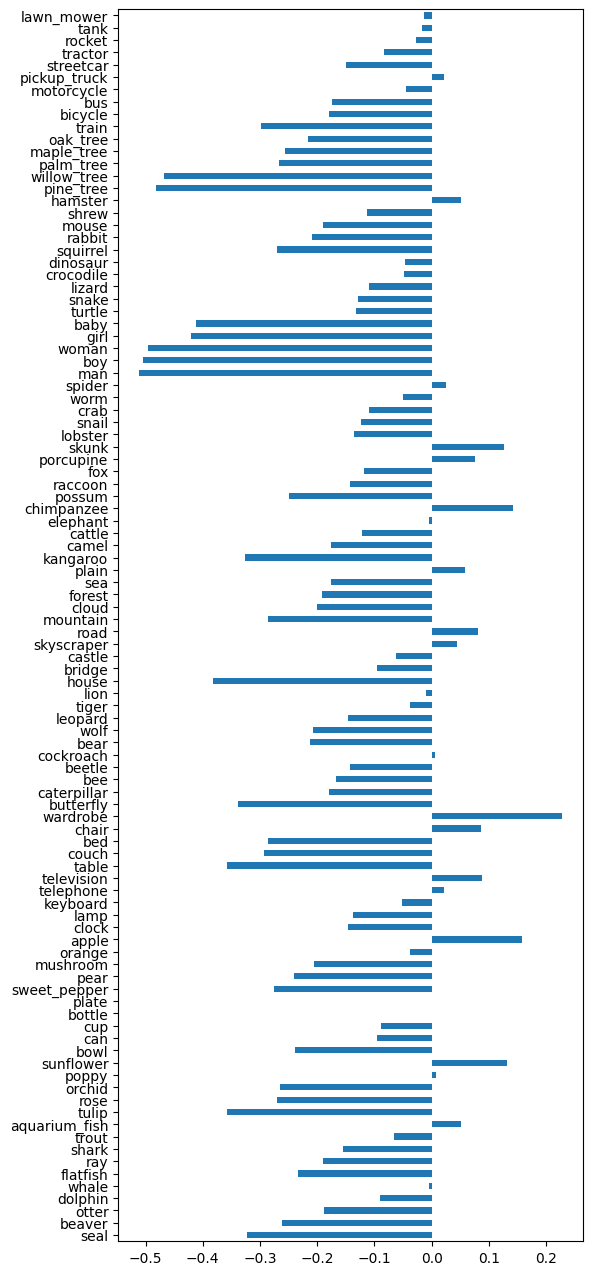

In [23]:
import pandas as pd

df = pd.DataFrame(
    {
     'label': F_label,
     'c_label': np.array([fine_to_coarse[i] for i in F_label]),
     'F_CF': F_precisions - CF_precisions,
     'F_C': F_precisions - C_precisions,
     'CF_C': CF_precisions - C_precisions,
    })

# График различия точности распознавания узкого класса и точности распознавания широкого класса по узкому
df.sort_values(by=['c_label', 'F_CF'],ascending=True).plot.barh(y='F_CF', x='label', legend=False, figsize=(6, 16), ylabel='')

График показывает различия точности распознавания узкого класса и точности распознавания широкого класса по узкому и позволяет сделать вывод, насколько точно определяется узкий класс в рамках широкого. Чем меньше значение, тем больше отличия в распозновании узкого класса.

<Axes: >

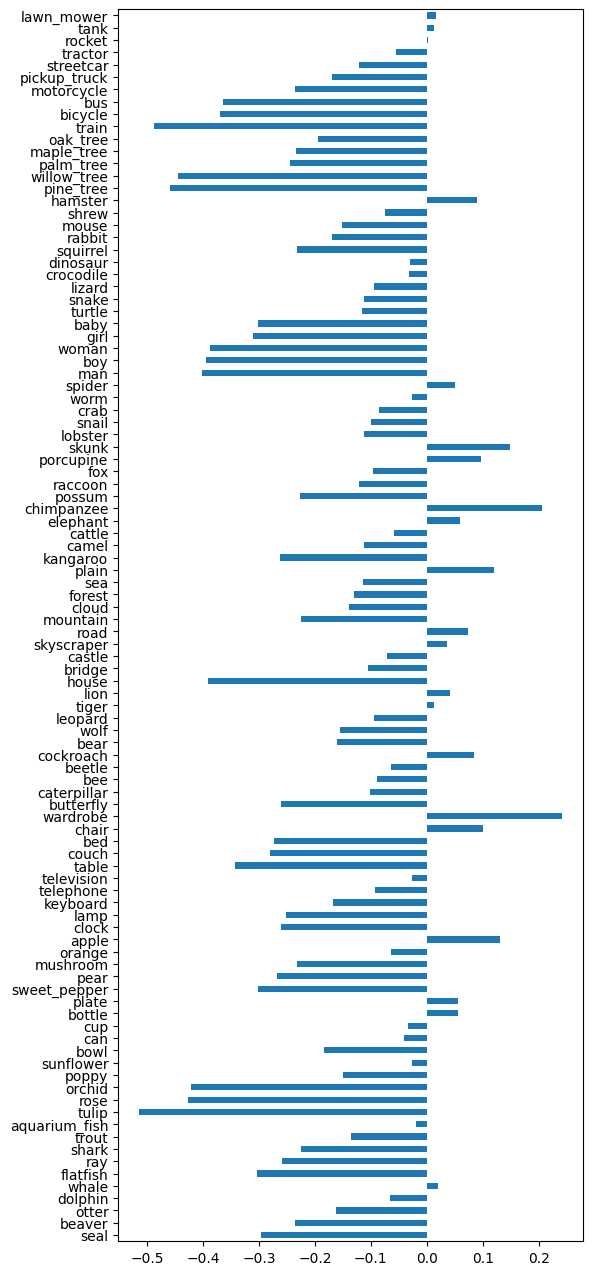

In [24]:
# График различия точности распознавания узкого класса и точности распознавания широкого класса
df.sort_values(by=['c_label', 'F_C'],ascending=True).plot.barh(y='F_C', x='label', legend=False, figsize=(6, 16), ylabel='')

График показывает различия точности распознавания узкого класса и точности распознавания широкого класса и позволяет сделать вывод о том, что модель определяет лучше широкие классы или узкие. 